## Modules/Dependencies

In [1]:
import setup
import numpy as np

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import colabtools

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [3]:
# more common libraries for retrieving data
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import audioread
import json
import os
import itertools
from PIL import Image
import cv2

## Register Catalog and Visualize Data

In [4]:
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
ds_train = '/home/shared/cuzokwe/train/'
ds_val = '/home/shared/cuzokwe/val/'
audio_metadata = MetadataCatalog.get("salami_2020_img_train")

In [5]:
# register training set data and metadata
DatasetCatalog.register("salami_2020_img_train", lambda ds_train=ds_train: setup.get_audio_dicts(ds_train))
MetadataCatalog.get("salami_2020_img_train").thing_classes = ["chorus", "verse","intro"]

In [6]:
# register validation set data and metadata
DatasetCatalog.register("salami_2020_img_val", lambda ds_val=ds_val: setup.get_audio_dicts(ds_val))
MetadataCatalog.get("salami_2020_img_val").thing_classes = ["chorus", "verse","intro"]

In [7]:
# unregister dataset
#DatasetCatalog.clear()

# show registered datasets
#DatasetCatalog.list()

In [8]:
audio_metadata = MetadataCatalog.get("salami_2020_img_train")
dataset_dicts_train = setup.get_audio_dicts(ds_train)

In [9]:
dataset_dicts_val = setup.get_audio_dicts(ds_val)

(322, 322, 3)
/home/shared/cuzokwe/train//images/608.png


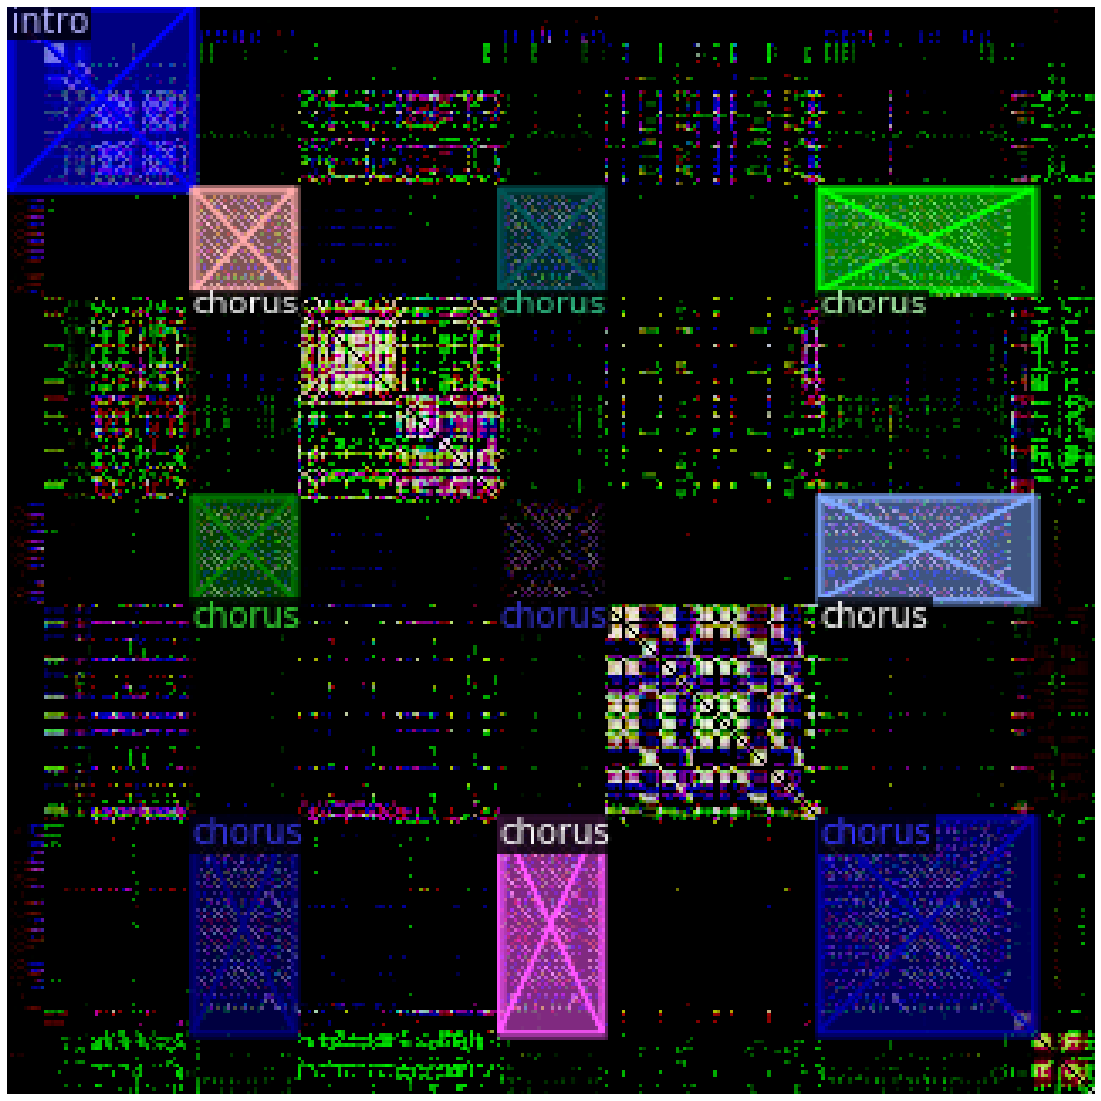

(516, 516, 3)
/home/shared/cuzokwe/train//images/598.png


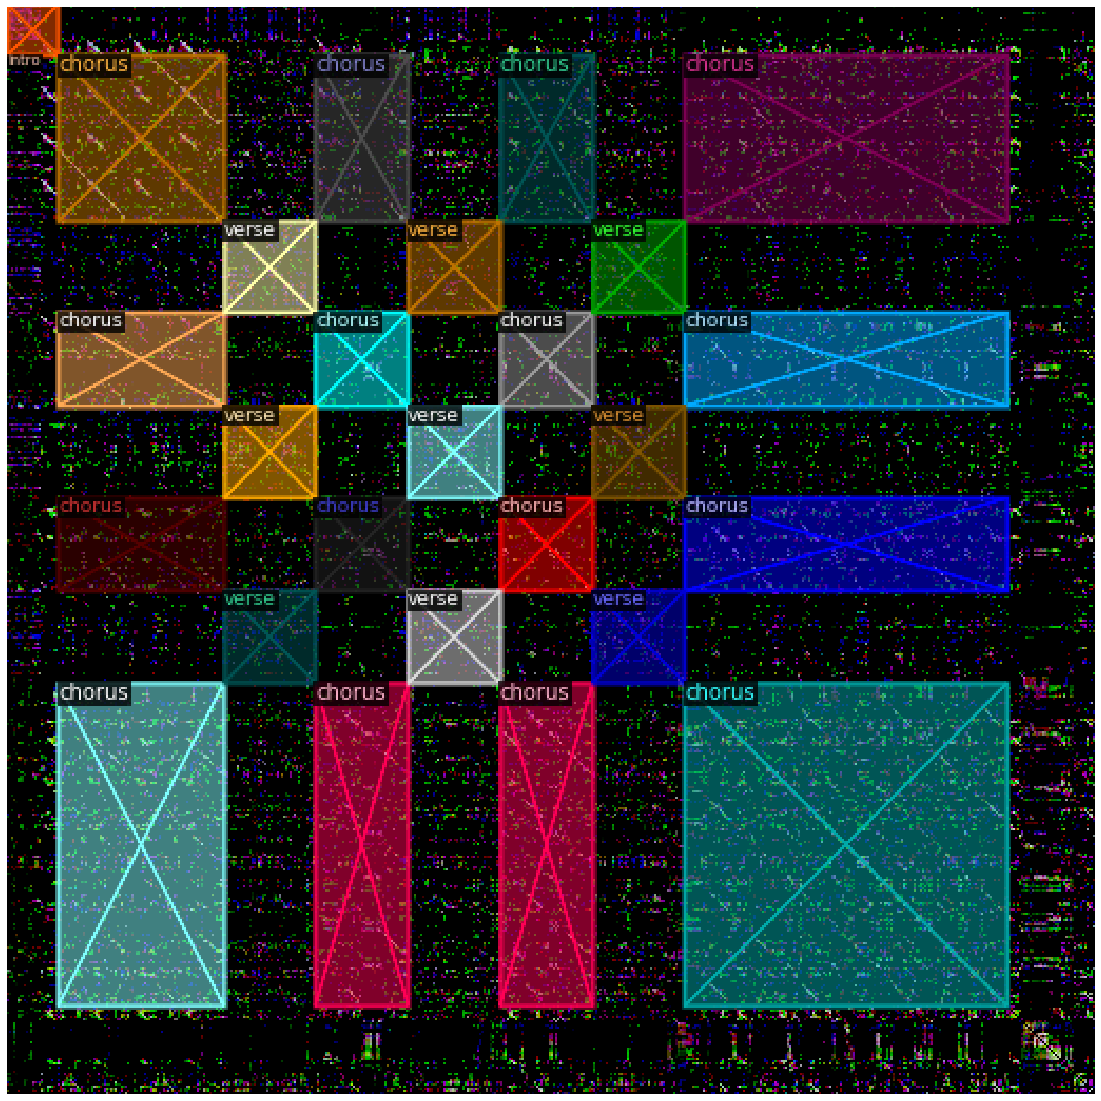

(506, 506, 3)
/home/shared/cuzokwe/train//images/636.png


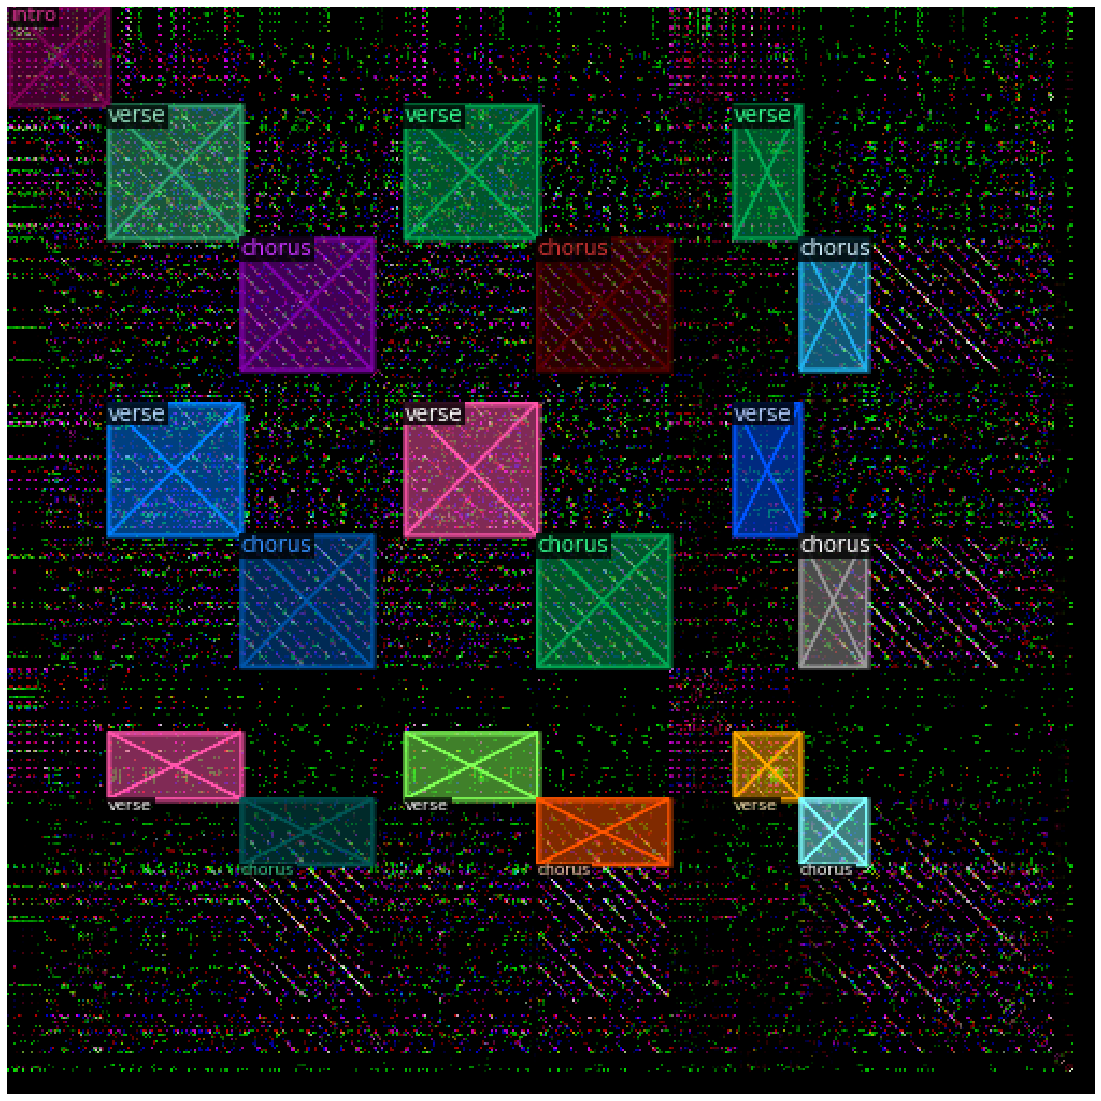

In [11]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    print(img.shape)
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=audio_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,20))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


## Train the Model

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("salami_2020_img_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 8500    # 7000 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # has classes intro, verse, chorus

In [ ]:



cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("salami_2020_img_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 8500    # 7000 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # has classes intro, verse, chorus

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("salami_2020_img_val", )
predictor = DefaultPredictor(cfg)
print(cfg.OUTPUT_DIR)

./output


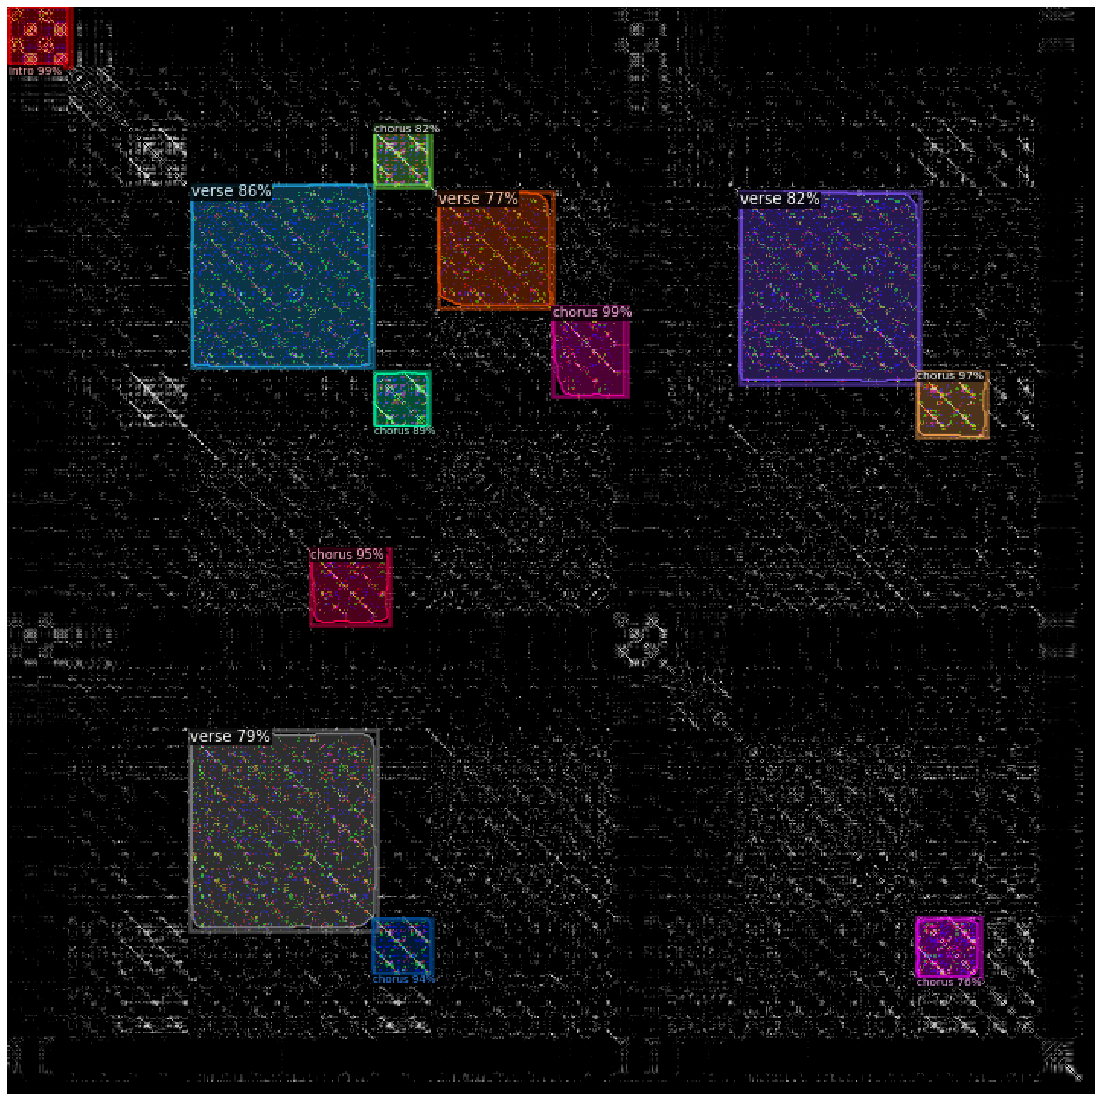

In [35]:
## fix this up (images), and try 

from detectron2.utils.visualizer import ColorMode
#for d in random.sample(dataset_dicts_val, 2):
im = cv2.imread(d["file_name"])
#print(d["file_name"])
outputs = predictor(im)
k = outputs["instances"]
j = k
#print(outputs["instances"].pred_classes[0])#[1].item())
#print(outputs)
v = Visualizer(im[:, :, ::-1],
               metadata=audio_metadata, 
               scale=1, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,20))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

(714, 714, 3)
/home/shared/cuzokwe/val//images/704.png


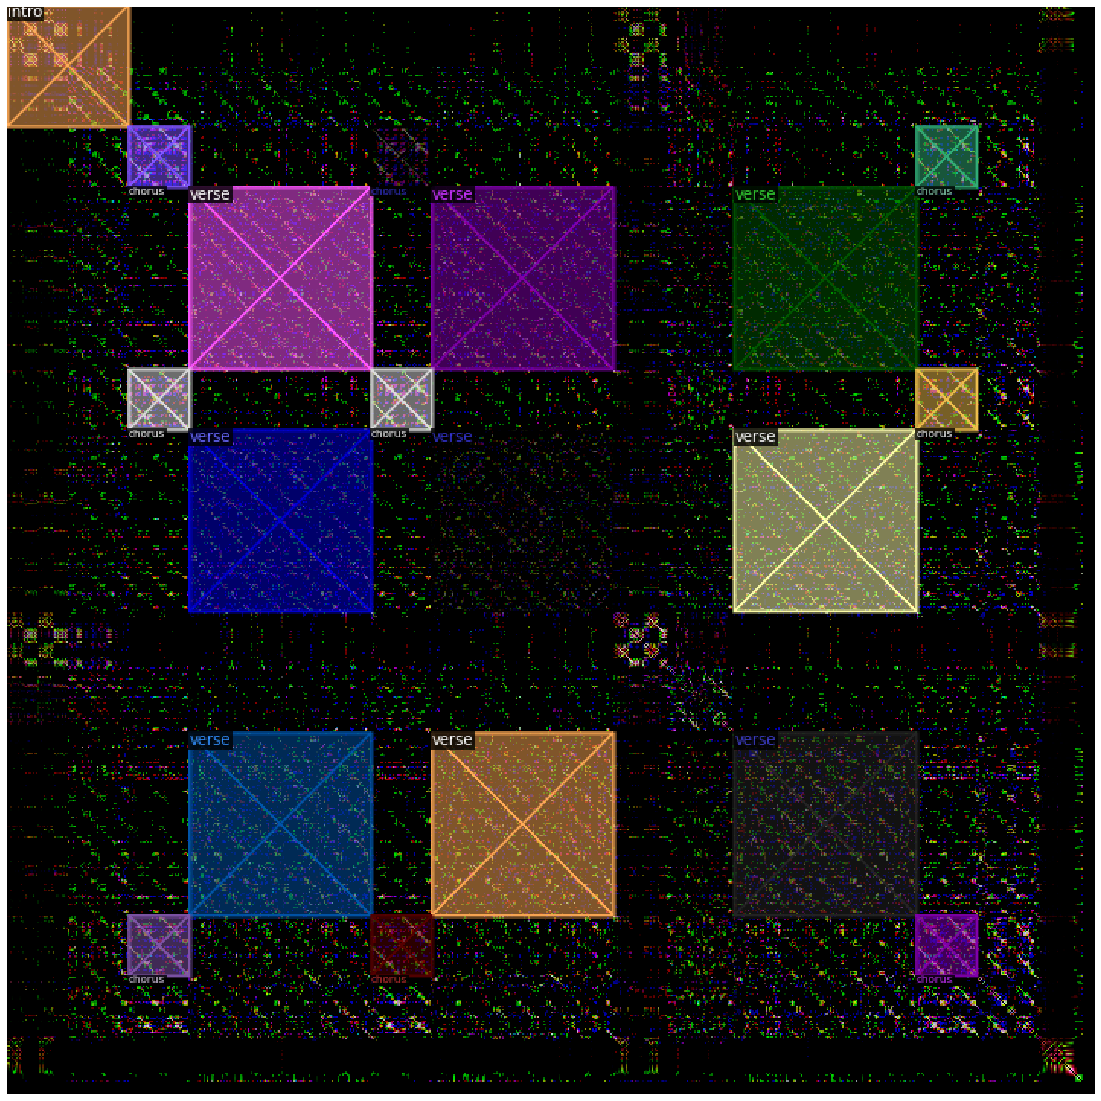

In [12]:
d = dataset_dicts_val[2]
img = cv2.imread(d["file_name"])
print(img.shape)
print(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=audio_metadata, scale=1)
vis = visualizer.draw_dataset_dict(d)
plt.figure(figsize=(20,20))
plt.imshow(vis.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

## Evaluation

In [76]:
""" compute the overlap accuracy of the diagonal image labels
 return [# of labels above threshold] & [average overlap %] """
def diagonal_acc(dataset_dict, outputs, threshold, alllabels = 0, label_type = 3):
    totalacc = 0
    numlabels = 0

     # find predicted bbox coordinates
    dpred = []
    i = 0
    for box in outputs["instances"].pred_boxes:
        tmp = []
        if abs(box[0].item() - box[1].item()) < 5 or alllabels:
            for x in box:
                tmp.append(x.item())
            tmp.append(outputs["instances"].pred_classes[i].item())
            
            # only append matching labels, append all if indicated label is 3
            if label_type == 3: 
                dpred.append(tmp)
            elif outputs["instances"].pred_classes[i].item() == label_type:
                dpred.append(tmp)
                
        i = i+1

    # get diagonal dataset outline values (where x1 = y1)
    for prediction in dpred:
        acc = 0
        diff = 10000
        tmp = 0
        nearest_seg = []
        for gtruth in dataset_dict["annotations"]:
            if gtruth["bbox"][0] == gtruth["bbox"][1] or alllabels: # if diagonal entry, calculate smallest similarity
                for i in range(4):
                    tmp = tmp + abs(gtruth["bbox"][i] - prediction[i])

                if tmp < diff:
                    nearest_seg = gtruth["bbox"].copy()
                    label = gtruth["category_id"]
                    diff = tmp   
                tmp = 0
           
        nearest_seg.append(label)
 
        # calculate accuracy from nearest segment
        if prediction[2] < nearest_seg[0] and prediction[3] < nearest_seg[0]:
            acc = 0
        elif prediction[0] > nearest_seg[2] and prediction[1] < nearest_seg[2]:
            acc = 0
        else:
            overlaparea = (max(nearest_seg[0], prediction[0]) - min(nearest_seg[2],prediction[2])) * (max(nearest_seg[1], prediction[1]) - min(nearest_seg[3],prediction[3]))
            labelarea = (nearest_seg[2]-nearest_seg[0])*(nearest_seg[3]-nearest_seg[1])
            acc = overlaparea/labelarea
        
        if acc*100 > threshold:
            if prediction[4] == nearest_seg[4]:
                numlabels = numlabels + 1
                totalacc = totalacc + acc
    try:
        return numlabels, totalacc/numlabels*100
    except:
        print("No labels found. Lower threshold and try again.")
        return 0, 0


In [92]:
labels, avgacc = diagonal_acc(d, outputs, 0, 1)
print("num_labels",labels)
print(avgacc)

num_labels 6
90.07247527255845


In [15]:
# compute the f1 score using diagonal(time) label entries. return precision, recall, and f1
def diagonal_precision(dataset_dict, outputs, threshold, alllabels = 0, label_type = 3):
    correctlabels = 0
    numlabels = 0

    # find predicted bbox coordinates
    dpred = []
    i = 0
    for box in outputs["instances"].pred_boxes:
        tmp = []
        if abs(box[0].item() - box[1].item()) < 5 or alllabels:
            for x in box:
                tmp.append(x.item())
            tmp.append(outputs["instances"].pred_classes[i].item())
            
            # only append matching labels, append all if indicated label is 3
            if label_type == 3: 
                dpred.append(tmp)
            elif outputs["instances"].pred_classes[i].item() == label_type:
                dpred.append(tmp)
                
        i = i+1
        
    # get diagonal dataset outline values (where x1 = y1)
  
    for prediction in dpred:
        acc = 0
        tmp = 0
        diff = 10000
        nearest_seg = []
        for gtruth in dataset_dict["annotations"]:
            
            
            if gtruth["bbox"][0] == gtruth["bbox"][1] or alllabels:  # if diagonal entry, calculate smallest similarity
                for i in range(4):
                    tmp = tmp + abs(gtruth["bbox"][i] - prediction[i])
                
                if tmp < diff:
                    nearest_seg = gtruth["bbox"].copy()
                    label = gtruth["category_id"]
                    diff = tmp   
                tmp = 0
           
        nearest_seg.append(label)

        # calculate accuracy from nearest segment
        if prediction[2] < nearest_seg[0] and prediction[3] < nearest_seg[0]:
            acc = 0
        elif prediction[0] > nearest_seg[2] and prediction[1] < nearest_seg[2]:
            acc = 0
        else:
            overlaparea = (max(nearest_seg[0], prediction[0]) - min(nearest_seg[2], prediction[2])) * (
                        max(nearest_seg[1], prediction[1]) - min(nearest_seg[3], prediction[3]))
            labelarea = (nearest_seg[2] - nearest_seg[0]) * (nearest_seg[3] - nearest_seg[1])
            acc = overlaparea / labelarea

        if acc * 100 > threshold:
            numlabels = numlabels + 1
            if prediction[4] == nearest_seg[4]:
                correctlabels = correctlabels + 1
                
    return numlabels, correctlabels

In [16]:
numlabels, correctlabels = diagonal_precision(d, outputs, 0, 1, 1)
print(correctlabels)
print(numlabels)

4
4


In [16]:
def diagonal_recall(dataset_dict, outputs, threshold, alllabels = 0, label_type = 3):
    correctlabels = 0
    numlabels = 0

    # find predicted bbox coordinates
    dpred = []
    i = 0
    for box in outputs["instances"].pred_boxes:
        tmp = []
        if abs(box[0].item() - box[1].item()) < 5 or alllabels:
            for x in box:
                tmp.append(x.item())
            tmp.append(outputs["instances"].pred_classes[i])
            
            # only append matching labels, append all if indicated label is 3
            if label_type == 3: 
                dpred.append(tmp)
            elif outputs["instances"].pred_classes[i].item() == label_type:
                dpred.append(tmp)
                
        i = i+1

    # get diagonal dataset outline values (where x1 = y1)
    for prediction in dpred:
        acc = 0
        tmp = 0
        diff = 10000
        gtruthcount = 0
        nearest_seg = []
        for gtruth in dataset_dict["annotations"]:
            if gtruth["bbox"][0] == gtruth["bbox"][1] or alllabels:  # if diagonal entry, calculate smallest similarity
                gtruthcount = gtruthcount + 1
                for i in range(4):
                    tmp = tmp + abs(gtruth["bbox"][i] - prediction[i])
                
                if tmp < diff:
                    nearest_seg = gtruth["bbox"].copy()
                    label = gtruth["category_id"]
                    diff = tmp   
                tmp = 0
                
        nearest_seg.append(label)
        
        # calculate accuracy from nearest segment
        if prediction[2] < nearest_seg[0] and prediction[3] < nearest_seg[0]:
            acc = 0
        elif prediction[0] > nearest_seg[2] and prediction[1] < nearest_seg[2]:
            acc = 0
        else:
            overlaparea = (max(nearest_seg[0], prediction[0]) - min(nearest_seg[2], prediction[2])) * \
                          (max(nearest_seg[1], prediction[1]) - min(nearest_seg[3], prediction[3]))
            labelarea = (nearest_seg[2] - nearest_seg[0]) * (nearest_seg[3] - nearest_seg[1])
            acc = overlaparea / labelarea

        if acc * 100 > threshold:
            numlabels = numlabels + 1
            if prediction[4] == nearest_seg[4]:
                correctlabels = correctlabels + 1

    return gtruthcount, correctlabels

In [18]:
gtruthlabels, correct = diagonal_recall(d, outputs, 0, 1)
print(correct)
print(gtruthlabels)

10
19


In [29]:
def single_f1(dataset_dict, outputs, threshold, alllabels = 0, label_type = 3):
    a, b = diagonal_recall(dataset_dict, outputs, threshold, alllabels, label_type)
    recall = b/a

    a, b = diagonal_precision(dataset_dict, outputs, threshold, alllabels, label_type)
    precision = b/a

    f1 = 2*((precision*recall)/(precision+recall))

    return b, f1

In [31]:
single_f1(d, outputs, 0, 1)

(10, 0.6451612903225806)

In [18]:
def model_f1(dataset, predictor, threshold, alllabels = 0, label_type = 3):
    total_predicted_labels = 0
    total_correct_labels = 0
    
    total_ground_truth_labels = 0
    total_correct_gtruth_labels = 0
    
    total_acc = 0
    samplecount = 0
    for d in dataset:
        if d["annotations"] == []:
            continue
            
        cv2.imread(d["file_name"])
        outputs = predictor(img)
        
        """
        labelct, acc = diagonal_acc(d, outputs, threshold, alllabels, label_type)
        print(d["file_name"],acc)
        total_acc = total_acc + acc
        samplecount = samplecount + 1"""
        
        a, b = diagonal_recall(d, outputs, threshold, alllabels, label_type)
        total_ground_truth_labels = total_ground_truth_labels + a
        total_correct_gtruth_labels = total_correct_gtruth_labels + b
        
        c, d = diagonal_precision(d, outputs, threshold, alllabels, label_type)
        total_predicted_labels = total_predicted_labels + c 
        total_correct_labels = total_correct_labels + d
    
    total_recall = total_correct_gtruth_labels/total_ground_truth_labels
    total_precision = total_correct_labels/total_predicted_labels
    #averageacc = total_acc/samplecount
    
    f1 = 2*((total_precision*total_recall)/(total_precision+total_recall))
    return total_correct_labels, total_precision, total_recall, f1
        

In [19]:
model_f1(dataset_dicts_val, predictor, 0, 1)

(224, 0.36661211129296234, 0.2087604846225536, 0.2660332541567696)

In [20]:
model_f1(dataset_dicts_val, predictor, 0, 0)

(119, 0.46303501945525294, 0.3953488372093023, 0.42652329749103945)

#per training run
#modelparameters(title) (threshold)
Segment      totalcorrectlabels          accuracy         precision          recall         f1
  all           d#     all#             d%, all%
 chorus                                 d%, all%
 verse                                  d%, all%
 intro                                  d%, all%

In [25]:
import prettytable as pt
threshold = 95

x = pt.PrettyTable()

x.fieldnames = ["Segment", "Correct Labels", "Avg Acccuracy", "Precision", "Recall", "F1"]



x.add_row(["all", ])



In [24]:
## Only Diagonal Labels, 50% Threshold
model_f1(dataset_dicts_val, predictor, 50, 0)

(69, 0.42857142857142855, 0.2292358803986711, 0.2987012987012987)

In [25]:
## All Labels, 50% Threshold
model_f1(dataset_dicts_val, predictor, 50, 1)

(105, 0.2807486631016043, 0.097856477166822, 0.14512785072563925)

In [27]:
## Diagonal Intro 50% Overlap Threshold
model_f1(dataset_dicts_val, predictor, 50, 0, 2)

(36, 0.8780487804878049, 0.11960132890365449, 0.2105263157894737)

In [29]:
## All Intros 50% Overlap Threshold
model_f1(dataset_dicts_val, predictor, 50, 1, 2)

(36, 0.8780487804878049, 0.033550792171481825, 0.06463195691202872)

In [30]:
## Diagonal Chorus  50% Overlap Threshold
model_f1(dataset_dicts_val, predictor, 50, 0, 0)

(22, 0.3013698630136986, 0.07308970099667775, 0.1176470588235294)

In [31]:
## All Chorus 50% Overlap Threshold
model_f1(dataset_dicts_val, predictor, 50, 1, 0)

(41, 0.211340206185567, 0.03821062441752097, 0.06471981057616416)

In [32]:
## Diagonal Verse 50% Overlap Threshold
model_f1(dataset_dicts_val, predictor, 50, 0, 1)

(11, 0.23404255319148937, 0.036544850498338874, 0.0632183908045977)

In [33]:
## Diagonal Verse 50% Overlap Threshold
model_f1(dataset_dicts_val, predictor, 50, 1, 1)

(28, 0.2014388489208633, 0.0260950605778192, 0.0462046204620462)